# Downloading Overlays

This notebook demonstrates how to connect a machine vision [MT9V034](https://www.onsemi.com/pub/Collateral/MT9V034-D.PDF) image sensor to the Ultra96 board. The sensor is attached to the hight range gpio expansion on the board. In the PL, these signals are converted to AXI stream and sent to the RAM throug one of the HP interfaces and a VDMA IP.
## 1. Imort the libraries and configure the PL


In [2]:
import numpy as np
from pynq import PL
from pynq import Overlay
import matplotlib.pyplot as plt
import cv2
from pynq.lib.video import *
ol = Overlay('/home/xilinx/overlays/soc.bit')

## 2. Configure the image pipeline

Before being sent into the RAM, the pixels should be converted into a format compatible with the Pynq drivers. There are two converter blocks, the first on transforms the color space of the pixels which we use here to convert the color image into a grayscale one and the other is to pack the pixel data into the 32 bit memory locations.

In [3]:
# Pixel Format
pixel_in = ol.pixel_pack_0

pixel_in.bits_per_pixel = 24

# Color mapping
colorspace_in = ol.color_convert_0

rgb2gray = [0.5, 0.5, 0.5,
           0.5, 0.5, 0.5, 
           0.5, 0.5, 0.5,
           0, 0, 0]
colorspace_in.colorspace = rgb2gray

# Initilize the AXI Stream Switches

In [4]:
axis_sw_input=ol.axis_switch_0
axis_sw_output=ol.axis_switch_1
def set_image_pipeline(val):
    if val==1:
        print('Setting the pipleine to Edge detection...')
        axis_sw_input.write(0x40,0x80000000)
        axis_sw_input.write(0x44,0x0)
        axis_sw_input.write(0x0,0x2)
        axis_sw_output.write(0x40,0x1) #Set the output to the processed image
        axis_sw_output.write(0x0,0x2)
    elif val==2:
        print('Setting the pipleine to raw Image...')
        axis_sw_input.write(0x40,0x0)
        axis_sw_input.write(0x44,0x80000000)
        axis_sw_input.write(0x0,0x2)
        axis_sw_output.write(0x40,0x0) #Set the output to the raw Stream 
        axis_sw_output.write(0x0,0x2)
    else:
        print('Invalid argument!, Value should be either 1 or 2.')

In [10]:
set_image_pipeline(1)

Setting the pipleine to Edge detection...


## 3. Initializing the VDMA

Now we need to initialize the VDMA so that it starts writing the frames into the RAM

In [7]:
cam_vdma = ol.axi_vdma_0
framemode = VideoMode(752, 480, 24)
# Set the read channel parameters to the camrea specifications and enable the VDMA
cam_vdma.readchannel.mode = framemode
cam_vdma.readchannel.start()


## 4. Initializing the DesplayPort

Now we need to initialize the DisplayPort so that we can show the camera frames on the monitor.

In [8]:
vidmode=VideoMode(1024,768,24)
vidOut=DisplayPort()
vidOut.configure(vidmode,PIXEL_RGB)
frameOut=vidOut.newframe()
vidOut.writeframe(frameOut)

## 5. Let's see if we can get a frame

In this step, we grab one frame form the camera and plot it here in the jupyter.

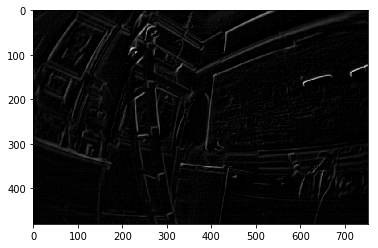

In [11]:
frame_camera = cam_vdma.readchannel.readframe()
#frame_gray=cv2.cvtColor(frame_camera,cv2.COLOR_RGB2GRAY)
plt.imshow(frame_camera[:,:,0],cmap='gray')
plt.show()

## 6. Displaying the camera images on the monitor

Now that everything is working fine, let's stram some frames on the monitor.

In [ ]:
while True:
    set_image_pipeline(2)
    for i in range(0,100):
        frame_camera = cam_vdma.readchannel.readframe()
        frameOut[0:480,0:752,:]=frame_camera
    set_image_pipeline(1)
    for i in range(0,100):
        frame_camera = cam_vdma.readchannel.readframe()
        frameOut[0:480,0:752,:]=frame_camera


## 7. Recoring the frames into a video file

We can also record a video file using the openCV

In [ ]:
out = cv2.VideoWriter('/home/xilinx/outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 60, (752,480))
while True:
    set_image_pipeline(2)
    for i in range(0,100):
        frame_camera = cam_vdma.readchannel.readframe()
        out.write(frame_camera)    
    set_image_pipeline(1)
    for i in range(0,100):
        frame_camera = cam_vdma.readchannel.readframe()
        out.write(frame_camera)
        

In [ ]:
out.release()

## 8. Releasing the resources

Finally when we're done, we should release the VDMA and Displayport.

In [ ]:
cam_vdma.readchannel.stop()
vidOut.close()